# IMA 208 TP5: homography estimation
## Giovanni BENEDETTI DA ROSA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In this practical work, we will study how to estimate an homography between two given images. We will consider both the simple DLT algorithm (part I) and the RANSAC algorithm (part II).

To reduce the time you need for this practical work, we will use a few pre-implemented functions of openCV. Make sure that your library installation is correct before starting to work.

# Part 1: homography estimation from hand-selected keypoints: DLT algorithm

We assume that we have an image of a documents suffering from severe perspective distortion. The objective of this part is to warp this image (denoted in the following as img2) to remove the distortion using a reference image beeing in the desired pose (denoted as img1).

The following cell enables to vizualize the images using openCV.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x24722082230>)

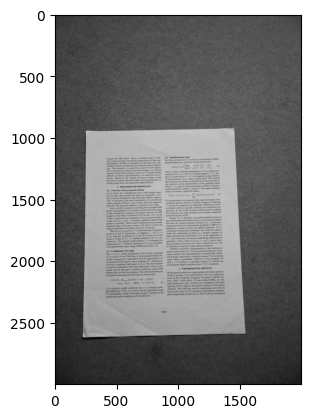

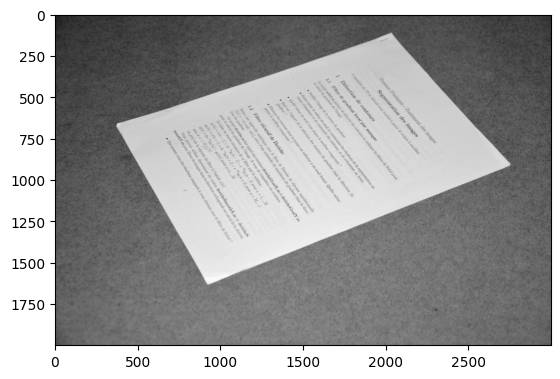

In [2]:
img1 = cv2.cvtColor(cv2.imread('Feuille_redressee.jpg'),cv2.COLOR_BGR2GRAY) # Reference image
img2 = cv2.cvtColor(cv2.imread('Feuille.jpg'),cv2.COLOR_BGR2GRAY) # Image to be processed

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To correct the homography beetween the to images, we will need some points to match between the two images.

**Question:** how many points do you at least need to estimate the homography? Why?


**Answer:** We need at least 8 points(4 for each image). This is because a homography matrix has eight degrees of freedom (since it's a 3x3 matrix), but each point correspondence provides two equations (one for the x-coordinate and one for the y-coordinate). With four points, you have eight equations, which is sufficient to solve for the eight unknowns in the homography matrix.

**Implementation:** to estimate the homography, some matching keypoints between the reference image and the to-be-porcessed one are given below. They here correspond to the corners of the two documents.

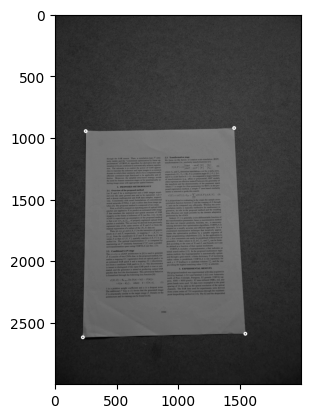

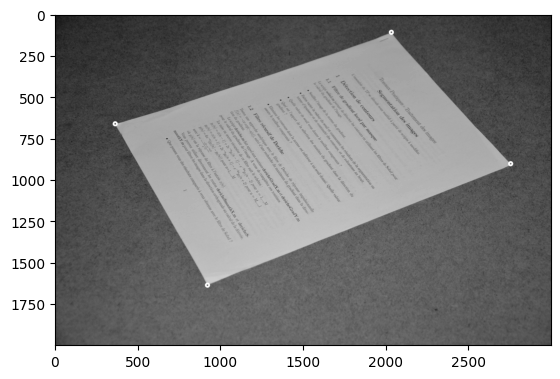

In [3]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663]] # Keypoints for img2,  keep the same order of the points as pts1.

# Below, we convert the points you found above into cv2 points object for vizualization (no need to change anything)
kp1 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts1]
kp2 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts2]

for i in range(len(pts1)):
    img1c=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c,cmap='gray')

for i in range(len(pts2)):
    img2c=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points

**Visualize** the keypoints you found above to check that they are properly assigned.

Now, we will start implementing the DLT.

**Question:** recall what the DLT is. Give a pseudo code. What are its potential flaws and strengths?

**Answer:** The DLT(Direct Linear Transformation) algorithm is method of estimating homography matrix beetween that corresponds to two images. It's an iterative method that minimizes the algebraic error between the predicted and observed image points.

$$\arg\min_{\mathbf{h} \in \mathbb{R}^9} \left\| \mathbf{Ah} \right\|_2^2 \quad \text{s.t.} \quad \left\| \mathbf{h} \right\|_2^2 =1$$


The pseudo-code of the algorithm with normalization can be seen as:

Given $n \geq 4$, in a $2\mathrm{D}$ to $2\mathrm{D}$ point correspondences $\left\{\mathbf{x}_i \leftrightarrow \mathbf{x}_i^{\prime}\right\}$, the objective is to determinehomography matrix H such that $\mathbf{x}_i^{\prime}=\mathrm{H} \mathbf{x}_i$.

1. Normalization of $\mathrm{x}$, using a similrity transformation(translation and scaling) such that the centroid of the new points is the coordinate origin $(0,0)^{\top}$, and their average distance from the origin is $\sqrt{2}$.

1. Normalization of $\mathrm{x}^{\prime}$ in an analogous way that in the previous step, using a transformation $T^{\prime}$

1. Apply DLT:
    1. For each correspondence $\mathbf{x}_i \leftrightarrow \mathbf{x}_i^{\prime}$ compute the matrix $A_i$ from (4.1). Only the first two rows need be used in general. A matrice
    1.  Assemble the $n 2 \times 9$ matrices $\mathrm{A}_i$ into a single $2 n \times 9$ matrix $\mathrm{A}$. $\mathbf{A} = \begin{bmatrix}
0 & 0 & 0 & -x_i & -y_i & -1 & x_i' y_i & x_i' x_i & x_i' \\
x_i & y_i & 1 & 0 & 0 & 0 & -x_i' y_i & -y_i' y_i & -y_i' \\
\end{bmatrix}
$
    1. Obtain the SVD of A . The unit singular vector corresponding to the smallest singular value is the solution $h$. Specifically, if $A=U D V^{\top}$ with $D$ diagonal with positive diagonal entries, arranged in descending order down the diagonal, then $\mathbf{h}$ is the last column of $\mathrm{V}$.
    1. The matrix $H$ is determined from $h$, which is reshaped into a $3 \times 3$ matrix H, with the elements filled in row-wise from hn and normalized so that $h_{33} =1$

1. Denormalize the data using $\mathrm{H}=\mathrm{T}^{\prime-1} \tilde{\mathrm{H}}$.

* Potential Flaws and Strengths of DLT:

The algorithm has a good accuracy when the noise level is low. Also, it is easy to implement and can be applied to various task. On the other hand, it can have problems related to noise, it requires a minimum number of corresponding points to accurately estimate the transformation and it may suffer from degeneracy in certain cases, such as when points are co-linear or co-planar, leading to ambiguities in the solution.

The first step of the DLT algorithm is to normalize the image point.

**Question:** Recall why the normalization is important. Recall how to do it.

**Answer:** How to normalize is described above, in the pseudocode.

Normalization of image points is crucial in the homography estimation process as it enhances numerical stability by ensuring coordinates are within a reasonable range, mitigates scaling effects between images caused by variations in zoom or resolution, reduces geometric distortion, and improves algorithm robustness against outliers and noise.

In the following, we will perform the normalization using the so called *homogeneous* coordinates of the keypoints. The main idea is to add a last coordinate equal to one for each point. The point (x,y) thus becomes (x,y,1) in homogeneous coordinate.

The advantage is that we will be able to do the normalization using a simple matrix product : X_norm = T@X.

**Fill** the blanks in the below implementation.

In [4]:
def normalize_image_points(imageEucl):
    """
    Input: 2D list with x,y image points
    Output: normalized data points
    """

    print("Normalizing data using similarity matrix...")
    
    mean, std = np.mean(imageEucl, axis=1), np.std(imageEucl, axis=1) # To be filled, (elementwise) mean and std of the data points
    
    # Image in homogeneous coordinate
    image = np.vstack((imageEucl, np.ones((imageEucl.shape[1])))) # Image in homogeneous coordinate
    

    # Define a similarity matrix enabling to normalize the data. Write the cooefficients in Tranformation such that image_norm = image@Transformation
    Transformation = np.array([ [1/std[0], 0, -mean[0]/std[0]],
                                [0, 1/std[1], -mean[1]/std[1]],
                                [0, 0, 1]   ])
    
    #Transformation = np.linalg.inv(Transformation)

    # Apply transformation on data points
    image_norm = Transformation@image
    
    # Retrieve normalized image in the original input shape (25, 2)
    image_norm = image_norm[0:2,:]

    return image_norm, Transformation



**Question:** Verify that your data looks properly normalized.

In [5]:
normalize_image_points(np.array(pts1))

Normalizing data using similarity matrix...


(array([[-0.98037024,  0.92643401,  1.07079273, -1.01685651],
        [-0.98490052, -1.01483671,  0.98250562,  1.0172316 ]]),
 array([[ 1.58635960e-03,  0.00000000e+00, -1.37378742e+00],
        [ 0.00000000e+00,  1.19744744e-03, -2.12127814e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

The second step is to compute the A matrix from the normalized data points.

**Fill** the blanks in the function below.

**Question:** justify the shape of the A matrix.

**Answer:** The A matrix can be built by
$$x' × Hx = 0$$
where $x$ and $x'$ are corresponding points in the two images. Each point correspondence contributes two rows to the $A$ matrix, representing the $x$ and $y$ components of the cross product. The structure of the $A$ matrix ensures that when it is multiplied by the homography vector $h$, the result ideally zeros, embodying the homography constraint for each point correspondence.  This means normally it should be the size $(8,9)$

In [6]:
def compute_matrix_A(points1, points2, no_points):
    """
    Input: Already normalized correspondences for image1 and image2
    Output: Matrix A as defined in Zisserman p. 91
    """

    A = []

    for i in range(0, no_points):
        x, y = points1[0, i], points1[1, i] # Denote the coordinate in image 1 x and y for shortcut
        x_prime, y_prime = points2[0, i], points2[1, i] # Denote the coordinate in image 2 x_prime and y_prime for shortcut

        # Create A_i according to the fomula given in class
        # here we are assuming w_i and w_i_prime are one
        A.append([0, 0, 0, -x, -y, -1, y_prime*x, y_prime*y, y_prime])
        A.append([x, y, 1, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime])
    print()
    print("Stacked matrix A shape:", np.shape(A))

    return np.asarray(A)

In [7]:
image1_normalized, T = normalize_image_points(pts1)
image2_normalized, T_prime = normalize_image_points(pts2)

# Get matrix A
# A = 
A = compute_matrix_A(image1_normalized, image2_normalized, pts1.shape[1])
A.shape

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)


(8, 9)

We are now ready to code the whole homography computation function. 

**Fill** the gaps below.

In [8]:
def compute_homography(pts1,pts2):

    # Set data points to numpy arrays
    no_points = pts1.shape[1] # Number of points

    # Normalize the data
    image1_normalized, T = normalize_image_points(pts1)
    image2_normalized, T_prime = normalize_image_points(pts2)
    
    # Get matrix A
    # A = 
    A = compute_matrix_A(image1_normalized, image2_normalized, no_points)
    
    # Compute SVD of A
    U, S, V = np.linalg.svd(A)
    V = V.T # So that A = USV.T
    
    # Get last column of V (this is the vector h)
    h = V[:,-1]
    
    # Obtain homography by reshaping h (H tilde)
    print()
    print("Reshaping to get homography H_tilde...")
    H_tilde = h.reshape(3,3)

    # Denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.linalg.inv(T_prime)@H_tilde@T

    print()
    print("Denormalized to obtain homography H for 2D data points...")
    print("Matrix H:")
    print(H)
    
    return H

**Question:** Apply the compute_homography function to warp the document image 2 into the perspective of document 1. Any comment ?

It seems the algorithm is working well, with a good initialization.

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.89756456e-01 -6.18024327e-01  1.80016938e+03]
 [ 3.58876320e-01  2.07702314e-01 -2.17795736e+02]
 [-6.16994599e-05 -4.83098365e-06  6.40932323e-01]]


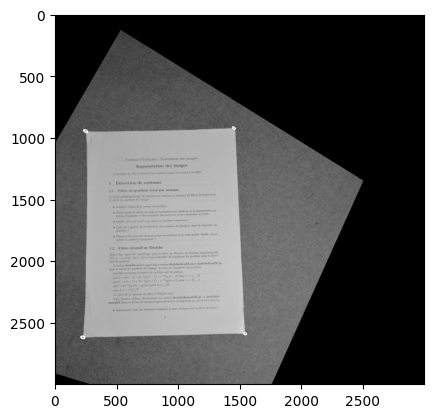

In [9]:
H = compute_homography(pts1,pts2)
homography_matrix_normalized = H
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

**Answer:**

**Question:** test the sensitivity of the above algorithm to errors in the matching keypoints. Are you able to obtain good results if you have a false match?

Answer to the same question is you have more matching points than the corners.

**Answer:** If we add more points that belongs to the border of the image the algorithm seems to work well, and in some cases I suppose it can increase the accuracy, eventough it has more computational complexity. With a false match the results are poor.

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.56889040e-01 -8.25580783e-01  2.31612907e+03]
 [ 3.06892665e-01  7.84680426e-02  6.78926218e+01]
 [-4.99226495e-05 -1.13115911e-04  8.24463866e-01]]


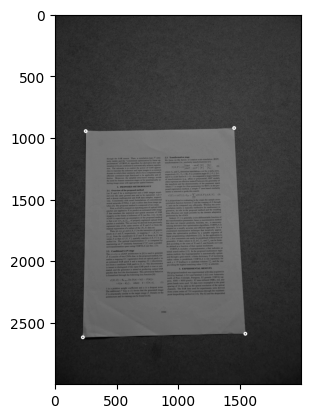

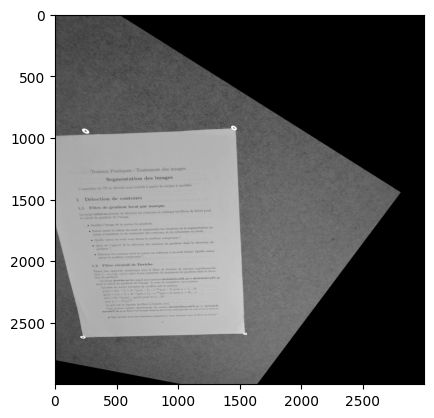

In [10]:
#error
error = 200
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030+error,110+error],[2750,904],[920,1638],[363,663]] # Keypoints for img2,  keep the same order of the points as pts1.



for i in range(len(pts1)):
    img1c_dec=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c_dec,cmap='gray')

for i in range(len(pts2)):
    img2c_dec=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c_dec,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points

H = compute_homography(pts1,pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.93293721e-01 -6.29544967e-01  1.83372648e+03]
 [ 3.65566162e-01  2.11574109e-01 -2.21855683e+02]
 [-6.28496044e-05 -4.92103839e-06  6.52879993e-01]]


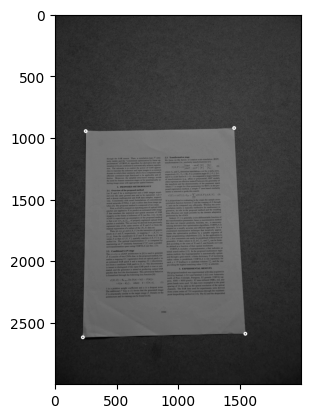

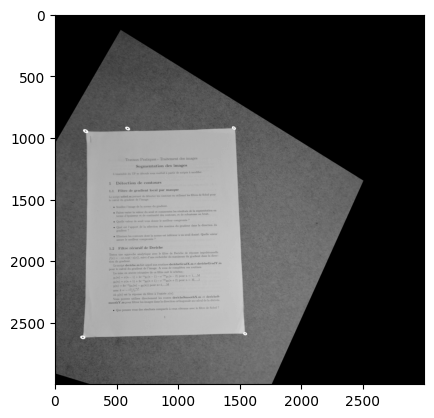

In [11]:
#more points
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663], [1000,2400]] # Keypoints for img2,  keep the same order of the points as pts1.



for i in range(len(pts1)):
    img1c_dec=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c_dec,cmap='gray')

for i in range(len(pts2)):
    img2c_dec=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c_dec,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points

H = compute_homography(pts1,pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

# Part 2: automatic homography estimation and panorama stitching

To bypass the flaws that we observed with the previous method, we now propose to use a robust homography estimation method, the RANSAC algorithm. As an application, we will consider panorama stitching: from two given overlapping images, create a single one which is a panorama. To do that, we will need to estimate the best homography to warp an image into the perspective of the other. In addition, to avoid the cumbersome choice of the matching points between the two images, we will do an automatic keypoint identification by using the SIFT features.

Let us first load the two considered images.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x247227decb0>)

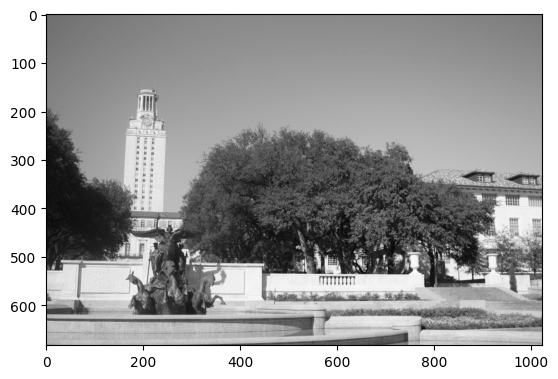

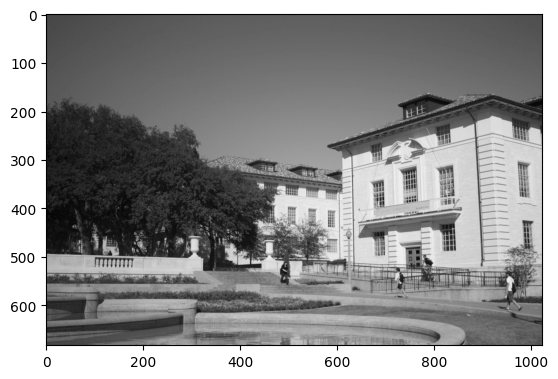

In [12]:
img1c = cv2.cvtColor(cv2.imread('uttower_left.jpg'),cv2.COLOR_BGR2GRAY)
img2c = cv2.cvtColor(cv2.imread('uttower_right.jpg'),cv2.COLOR_BGR2GRAY)

img1 = img1c
img2 = img2c

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To stitch the two images, we need to have access to pair of corresponding points between image 1 and image 2. To do that, we first need to extract some keypoints in both images (that will be matched later on). We will use here the SIFT descriptors.

**Implement** the SIFT descriptors for both image 1 and image 2. You might be willing to use the cv2.SIFT_create and sift.detectAndCompute.

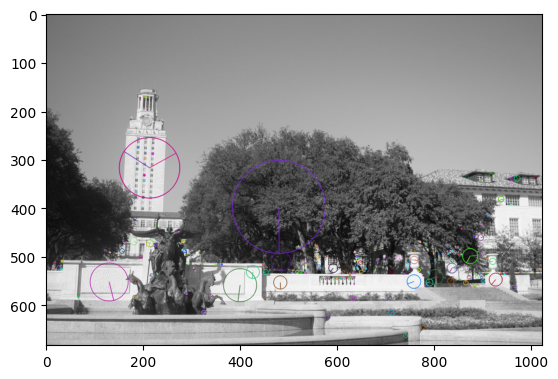

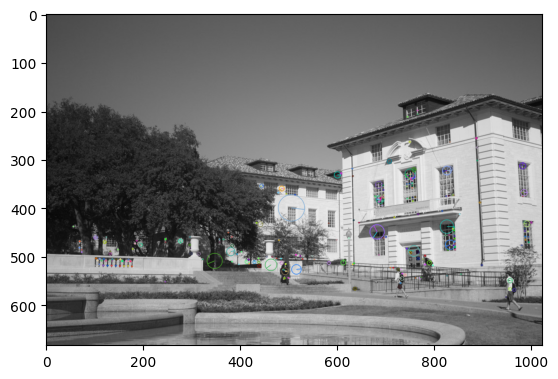

In [13]:
sift = cv2.SIFT_create(contrastThreshold=0.16) # Creates an object of the SIFT class. The larger the threshold, the smaller the number of points
kp1,desc1 = sift.detectAndCompute(img1, None) #kp1 = location of the keypoints, desc1 = corresponding descriptors.

# For visualization
img1c=cv2.drawKeypoints(img1,kp1,img1c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1c)
plt.show()

kp2,desc2 = sift.detectAndCompute(img2, None) #kp2 = location of the keypoints, desc2 = corresponding descriptors.
img2c=cv2.drawKeypoints(img2,kp2,img2c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2c)

**Question:** explain the shapes of desc1, kp1 and desc2, kp2 and their respective roles.

**Answer:**


Shapes: Descriptors (desc1, desc2) are indeed matrices where each row represents the feature descriptor of a keypoint, capturing the local image appearance around that point. The number of columns corresponds to the descriptor dimensionality, which is typically fixed (e.g., 128 dimensions for SIFT descriptors). Keypoints (kp1, kp2) are usually arrays of structures or objects containing the coordinates and possibly other information (like scale and orientation) of detected interest points in the images.

Roles: Keypoints are indeed used to identify distinctive locations in images that are invariant to scale, rotation, and lighting changes. These keypoints serve as anchor points for feature matching. Descriptors, on the other hand, provide a unique fingerprint for each keypoint, representing the local image appearance around that keypoint. These descriptors facilitate the matching of keypoints between different images by quantifying the local image structure in a way that is robust to changes in viewpoint, illumination, and other factors.

Now that we have obtained the SIFT descriptor, we have to match them.

**Complete** the following code.

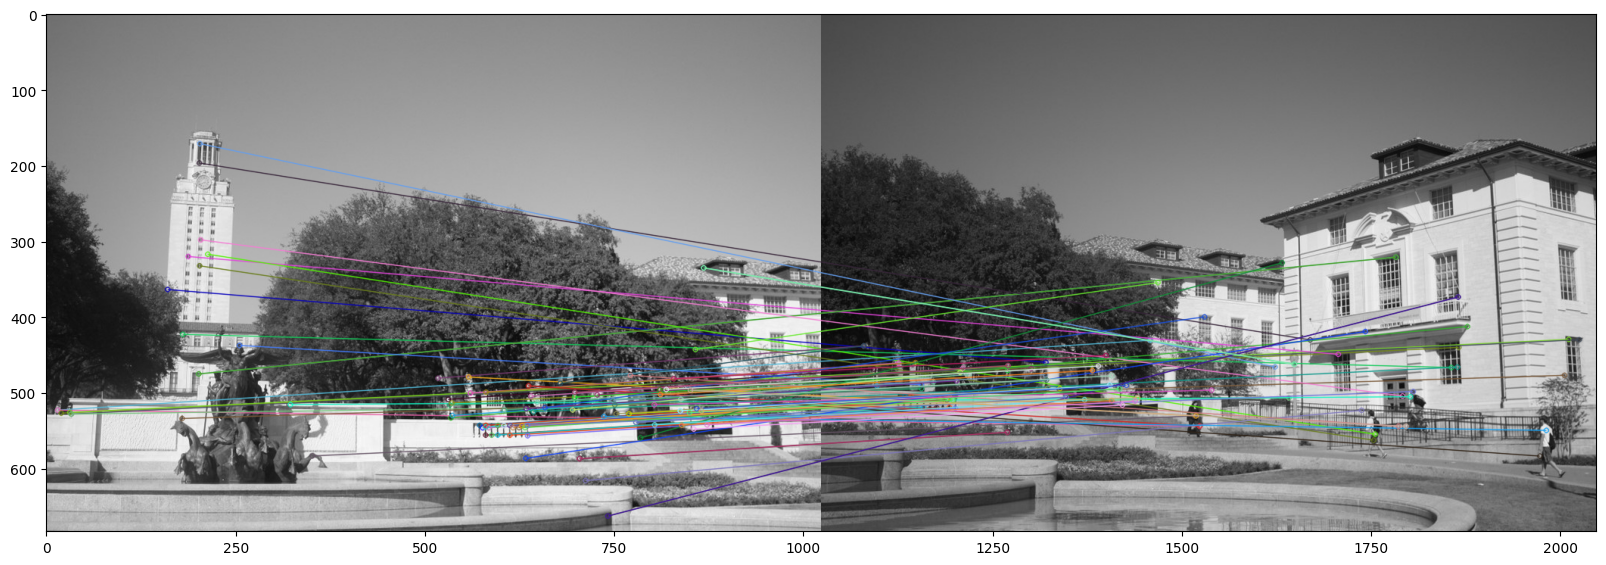

(<Figure size 2000x1200 with 1 Axes>,
 None)

In [14]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc1,desc2) 

#matches = bf.match(...,...) 


# For visualizing the matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], img2, flags=2)
plt.figure(figsize=(20,12)),plt.imshow(img3),plt.show()

**Question:** comment the match quality. Do you think that the previous matching would enable a decent homography computation using the DLT algorithm of the first part?

**Answer:**
I believe it would not lead to a decent classification once DLT, once there are some mismatches in the image above. This type of of problem  severely disturb the least-square based homography estimators, so I think It would not be possible to obtain a decent homography computation. 

The following code enables to keep only the coordinates of the 100 best matches in the two images. We will use them as an input of a RANSAC, which will enable to do a robust homography estimation between the two images.

In [15]:
D1 = np.ones((2,100)) # Coordinates in image 1 of the first best matching points
D2 = np.ones((2,100)) # Coordinates in image 2 of the first best matching points
for ii in range(100):
    D1[:,ii] = kp1[matches[ii].queryIdx].pt
    D2[:,ii] = kp2[matches[ii].trainIdx].pt
    D1 = D1.astype(int)
D2 = D2.astype(int)

In [16]:
print(D1.shape)

(2, 100)


Now, we are ready to code the RANSAC algorithm.

**Fill** the gaps in the code below.

In [17]:
def ransac(D1, D2, num, threshold, iterations):
    # D1, D2 : matched points between the two images
    # num : number of points to compute the homography
    # threshold : distance threshold for determining if a pair of point in an inlier or an outlier
    # iterations : number of iterations / number of sampling
    
    D1h = np.vstack((D1, np.ones(D1.shape[1]))) #D1h correspond to D1 transformed into homogeneous coordinates
    D1h[0:2,:] = np.divide(D1h[0:2,:],D1h[2,:])
    
    D2h = np.vstack((D2, np.ones(D2.shape[1])))#D2h correspond to D2 transformed into homogeneous coordinates
    D2h[0:2,:] = np.divide(D2h[0:2,:],D2h[2,:])
        
    n = D1.shape[1] # Number of points in D1
    

    best_n_inlier = 0
    best_H = np.zeros(D1h.shape) # Best homography matrix. Fill the gap with a matrix of the right size full of 0.
    
    for i in range(iterations):
        s = np.random.choice(n, num, replace=False)# Draw randomly 4 indices to extract 4 points among D1 and D2. You can use np.random.choice()
        
        pts1 =  D1[:, s] #pts1 is the chosen points among D1
        pts2 =  D2[:, s] #pts2 is the chosen points among D2
        
        H = compute_homography(pts1,pts2)# Compute the corresponding homography. You can reuse the function of part I.
        
        D2_new = np.dot(H, D1h) # Transform the points of D1h to be able to compare them to the ones of D2h
        
        # Normalize D2_new
        D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
        D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
        D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])
        
        
        
        SD = np.sqrt(np.sum((D2_new - D2h)**2, axis = 0))# Compute the distance between D2_new and D2h
        
        inliers = SD < threshold # Compute the inliers
        num_inlier = np.sum(inliers)# Compute the number of inliers
        
        if num_inlier > best_n_inlier: # If you obtained the best result, store the corresponding homography
            best_H = H
            best_n_inlier = num_inlier
            point1 = D1[:2, inliers]
            point2 = D2[:2, inliers]
            in_res = SD[inliers]
    
    
    return best_H, best_n_inlier, point1, point2, in_res

Using the function you implemented above, **launch the RANSAC algorithm** to estimate the homography between the two images.

In [18]:
threshold = 1;
num = 4;
iterations = 1000;
[H, inliers, point1, point2, residue] = ransac(D1, D2, num,threshold, iterations)

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-7.44176690e-01 -2.98374599e-01  6.01463230e+02]
 [-1.01576132e+00 -1.11572573e+00  1.14761473e+03]
 [-2.20956375e-03 -2.39924597e-03  2.48825710e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.65187853e-01  8.61914651e-01 -6.31659469e+02]
 [ 1.73486174e+00  1.91714412e+00 -2.52914151e+03]
 [ 3.54426208e-03  4.03804509e-03 -5.22990415e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-1.


Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-3.12517963e-01 -3.44324167e+00  1.99893234e+03]
 [ 6.60317905e-02 -2.46035622e+01  1.27307306e+04]
 [ 1.97501266e-04 -5.36780425e-02  2.77413061e+01]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 7.05490182e-02 -5.48222283e-01  2.81294845e+02]
 [ 3.43626081e-01 -5.54822835e-01  1.81988884e+02]
 [ 8.10823724e-04 -1.30869787e-03  3.96501858e-01]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 8.54530549e-01 -4.76204339e+00  1.87776812e+03]
 [ 1.15198006e+00 -6.28232059e+00  2.45610573e+03]
 [ 2.45343210e-03 -1.33

C:\Users\giova\AppData\Local\Temp\ipykernel_32924\2026613331.py:30: RuntimeWarning: invalid value encountered in divide
  D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
C:\Users\giova\AppData\Local\Temp\ipykernel_32924\2026613331.py:31: RuntimeWarning: invalid value encountered in divide
  D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
C:\Users\giova\AppData\Local\Temp\ipykernel_32924\2026613331.py:32: RuntimeWarning: invalid value encountered in divide
  D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])
C:\Users\giova\AppData\Local\Temp\ipykernel_32924\2026613331.py:30: RuntimeWarning: divide by zero encountered in divide
  D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
C:\Users\giova\AppData\Local\Temp\ipykernel_32924\2026613331.py:31: RuntimeWarning: divide by zero encountered in divide
  D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])



Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-3.94408877e-01  1.19891956e+00 -4.08343910e+02]
 [ 1.59207699e-01  4.27903108e-01 -3.25524774e+02]
 [ 7.78016314e-05  1.20910128e-03 -6.95717537e-01]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-5.54211688e-01 -1.74640652e+00  1.21648695e+03]
 [-5.99011671e-01 -8.30004895e+00  4.63542713e+03]
 [-1.32572119e-03 -1.66007114e-02  9.36875114e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-1.11909744e+00 -1.29371542e+00  1.53912889e+03]
 [-3.36997367e+00  7.89526510e-01  2.17034019e+03]
 [-6.77807777e-03  4.96

In [19]:
print(H)

[[ 6.23452872e-01 -6.04226825e-02 -2.61342158e+02]
 [ 7.96001425e-02  5.61140224e-01 -6.45692972e+01]
 [ 1.27029150e-04 -5.24858568e-05  5.21577057e-01]]


Lastly, **fill the code** below to warp img2 into the same space as img1

In [20]:
result = cv2.warpPerspective(img2, np.linalg.inv(H), (img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0], 0:img1.shape[1]] = img1

**Question:** Plot the panorama image. How good is it? Any comment?

**Answer:** Clearly the a good descriptor of the image is highly dependent of the contrast threshold parameter of the SIFt function. In this case, the results seems pretty good.

(<Figure size 4000x2000 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x24729b66410>)

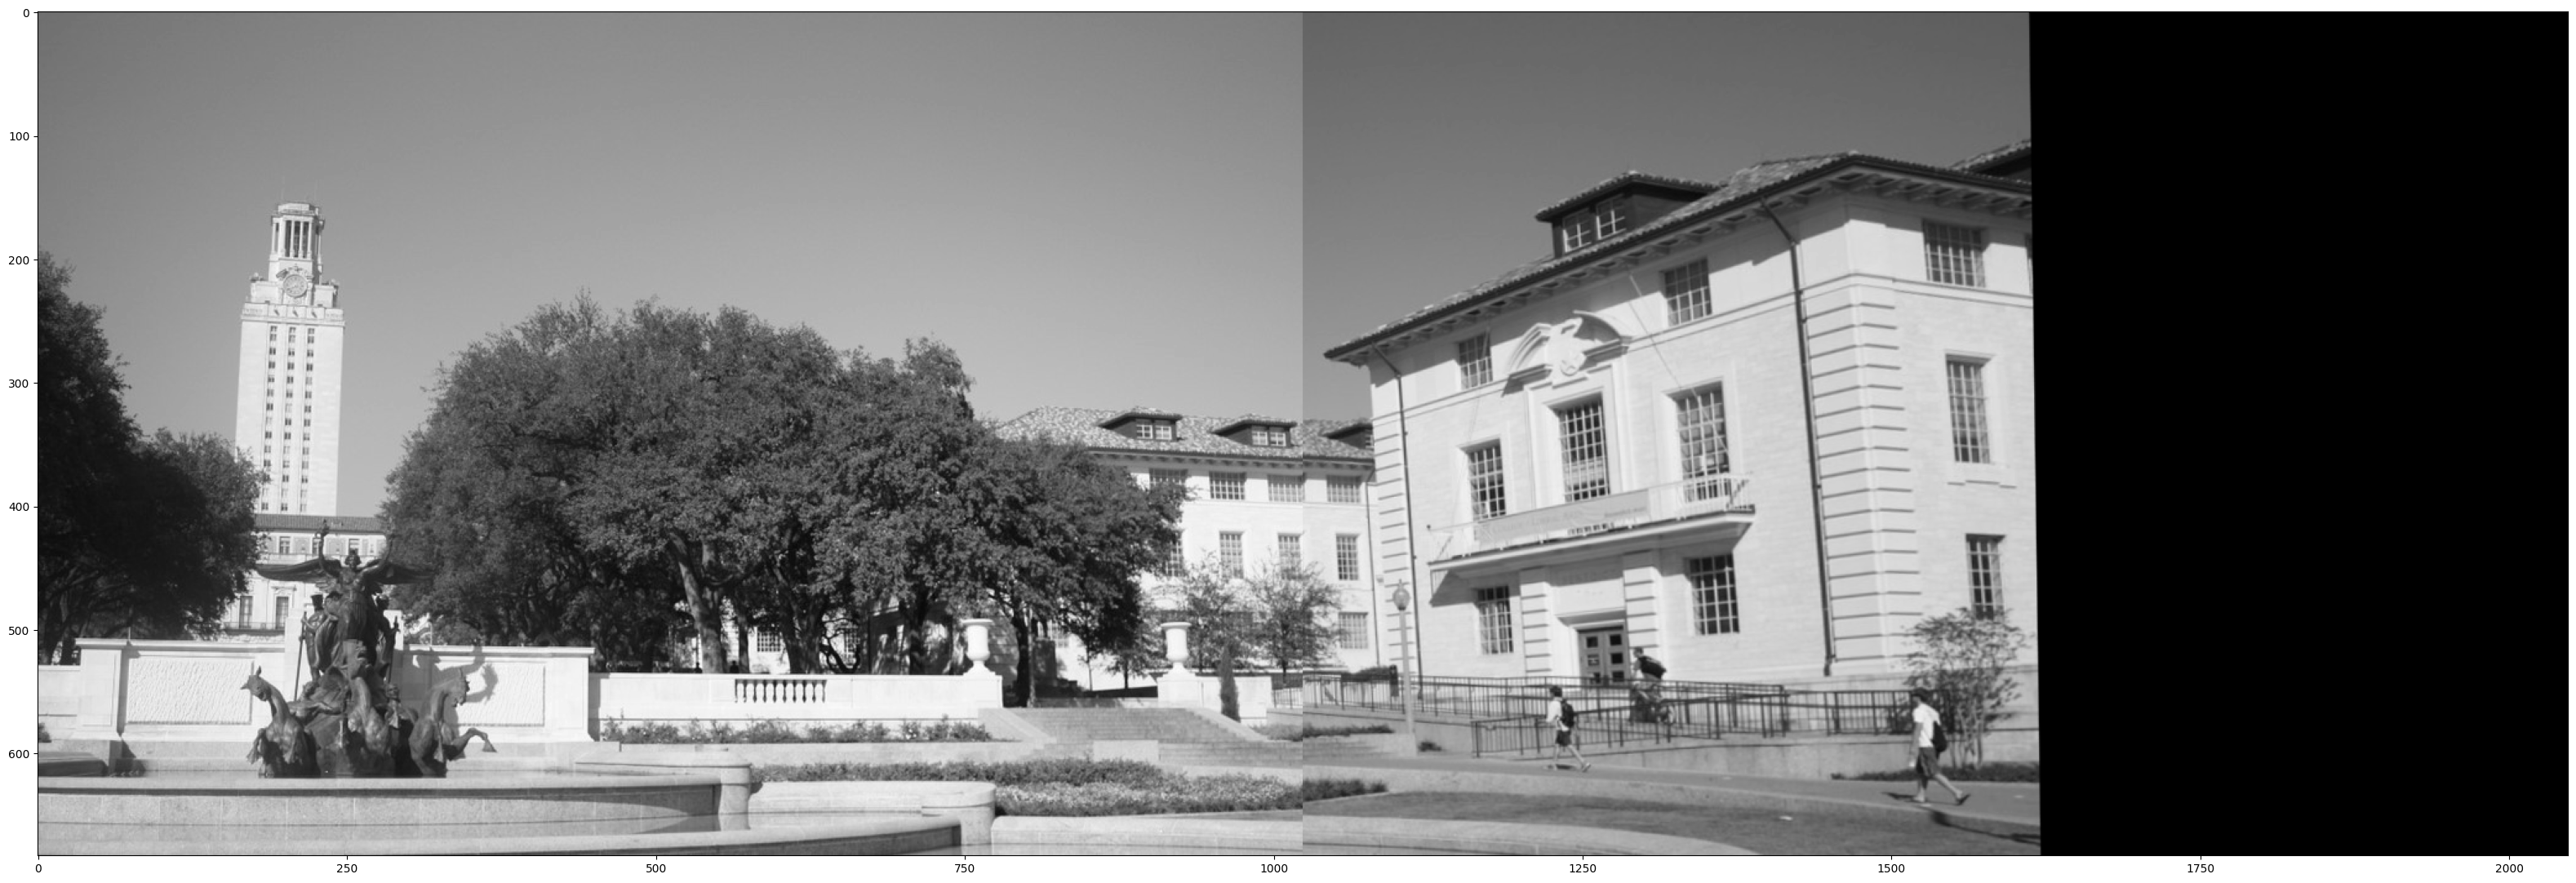

In [21]:
plt.figure(figsize=(40,20)),plt.imshow(result,cmap='gray')

(<Figure size 4000x2000 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x24729bf16c0>)

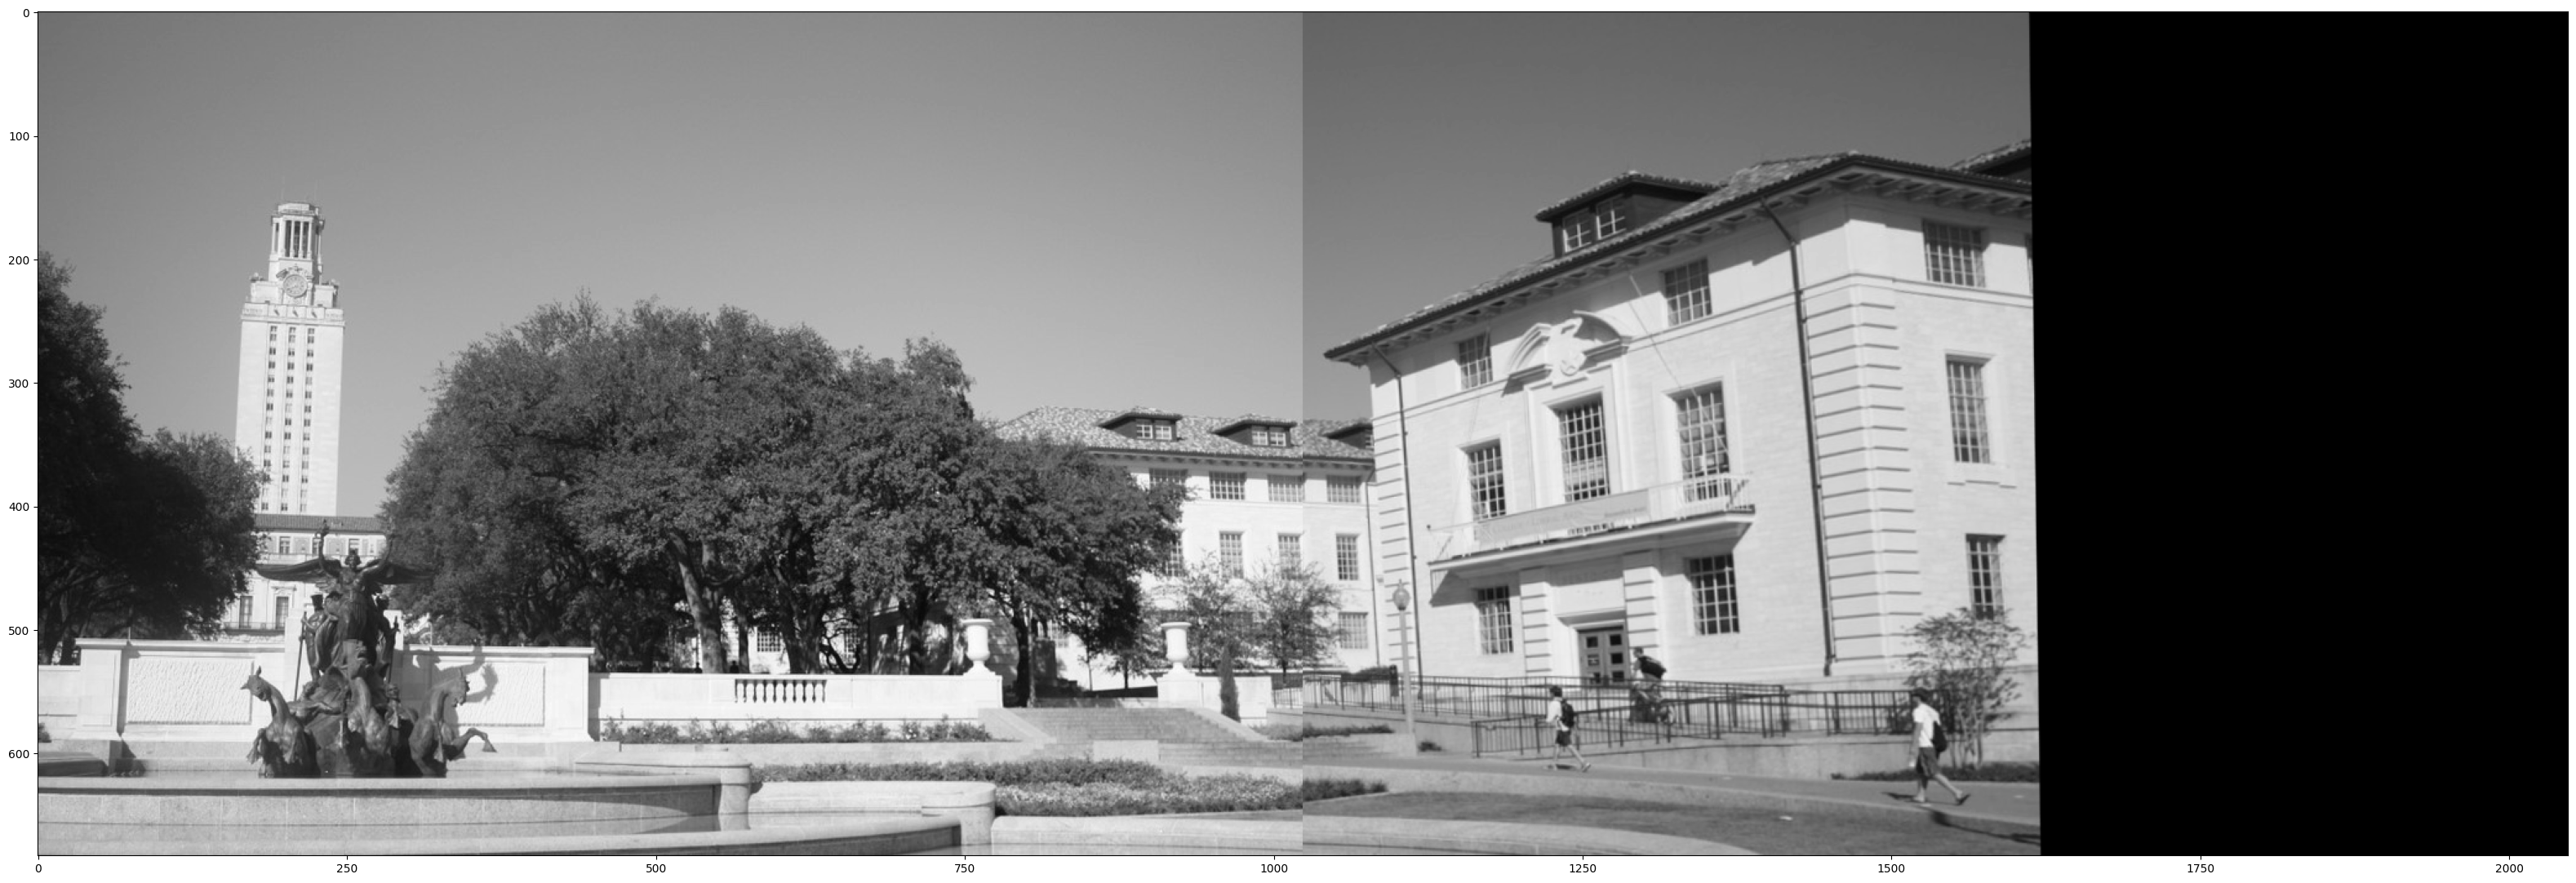

In [22]:
plt.figure(figsize=(40,20)),plt.imshow(result,cmap='gray')

**Bonus**: try other descriptors than the SIFT ones. Try to implement your own.

**Bonus:** try to correct the change of luminosity between the two images so that the panorama look more realistic.